# RNN LSTM Sequence Data

## 1. Load the data

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

nyt_dir = 'data/nyt_dataset/articles/'

all_headlines = []
for filename in os.listdir(nyt_dir):
    if 'Articles' in filename:
        # Read in all the data from the CSV file
        headlines_df = pd.read_csv(nyt_dir + filename)
        # Add all of the headlines to our list
        all_headlines.extend(list(headlines_df.headline.values))
len(all_headlines)

9335

## 2. Look at the data

In [2]:
# first 20

all_headlines[:20]

['N.F.L. vs. Politics Has Been Battle All Season Long',
 'Voice. Vice. Veracity.',
 'A Stand-Up’s Downward Slide',
 'New York Today: A Groundhog Has Her Day',
 'A Swimmer’s Communion With the Ocean',
 'Trail Activity',
 'Super Bowl',
 'Trump’s Mexican Shakedown',
 'Pence’s Presidential Pet',
 'Fruit of a Poison Tree',
 'The Peculiar Populism of Donald Trump',
 'Questions for: ‘On Alaska’s Coldest Days, a Village Draws Close for Warmth’',
 'The New Kids',
 'What My Chinese Mother Made',
 'Do You Think Teenagers Can Make a Difference in the World?',
 'Unknown',
 'President Pledges to Let Politics Return to Pulpits',
 'The Police Killed My Unarmed Son in 2012. I’m Still Waiting for Justice.',
 'Video of Sheep Slaughtering Ignites a Dispute',
 'This Will Change Your Mind']

## 3. Pre-process the data

### 3a. Clean the data

In [3]:
# Remove all headlines with the value of "Unknown"
all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

8603

In [4]:
all_headlines[:20]

['N.F.L. vs. Politics Has Been Battle All Season Long',
 'Voice. Vice. Veracity.',
 'A Stand-Up’s Downward Slide',
 'New York Today: A Groundhog Has Her Day',
 'A Swimmer’s Communion With the Ocean',
 'Trail Activity',
 'Super Bowl',
 'Trump’s Mexican Shakedown',
 'Pence’s Presidential Pet',
 'Fruit of a Poison Tree',
 'The Peculiar Populism of Donald Trump',
 'Questions for: ‘On Alaska’s Coldest Days, a Village Draws Close for Warmth’',
 'The New Kids',
 'What My Chinese Mother Made',
 'Do You Think Teenagers Can Make a Difference in the World?',
 'President Pledges to Let Politics Return to Pulpits',
 'The Police Killed My Unarmed Son in 2012. I’m Still Waiting for Justice.',
 'Video of Sheep Slaughtering Ignites a Dispute',
 'This Will Change Your Mind',
 'Busy Start for a President, and That Was in 1933']

### 3b. Tokenization

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenize the words in our headlines
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_headlines)
total_words = len(tokenizer.word_index) + 1
print('Total words: ', total_words)

Total words:  11753


In [6]:
# Print a subset of the word_index dictionary created by Tokenizer
subset_dict = {key: value for key, value in tokenizer.word_index.items() \
               if key in ['a','man','a','plan','a','canal','panama']}
print(subset_dict)

{'a': 2, 'plan': 82, 'man': 139, 'panama': 2931, 'canal': 5487}


In [7]:
tokenizer.texts_to_sequences(['a','man','a','plan','a','canal','panama'])

[[2], [139], [2], [82], [2], [5487], [2931]]

### 3c. Create sequences of tokens

In [8]:
# Convert data to sequence of tokens 

input_sequences = []
for line in all_headlines:
    # Convert our headline into a sequence of tokens
    token_list = tokenizer.texts_to_sequences([line])[0]
    
    # Create a series of sequences for each headline
    for i in range(1, len(token_list)):
        partial_sequence = token_list[:i+1]
        input_sequences.append(partial_sequence)

print(tokenizer.sequences_to_texts(input_sequences[:5]))
input_sequences[:5]

['n f', 'n f l', 'n f l vs', 'n f l vs politics', 'n f l vs politics has']


[[193, 125],
 [193, 125, 253],
 [193, 125, 253, 157],
 [193, 125, 253, 157, 226],
 [193, 125, 253, 157, 226, 83]]

In [9]:
# pad sequences to same length

from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Determine max sequence length
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences with zeros at the beginning to make them all max length
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
       193, 125], dtype=int32)

### 3d. Create predictors and target labels

In [10]:
# Predictors are every word except the last
predictors = input_sequences[:,:-1]
# Labels are the last word
labels = input_sequences[:,-1]

print(labels.shape, '\n')
labels[:5]

(53305,) 



array([125, 253, 157, 226,  83], dtype=int32)

In [11]:
# make labels categorical

from tensorflow.keras import utils

labels = utils.to_categorical(labels, num_classes=total_words)

print(labels.shape, '\n')
labels[:5]

(53305, 11753) 



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 4. Create the model

In [12]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

# Input is max sequence length - 1, as we've removed the last word for the label
input_len = max_sequence_len - 1 

model = Sequential()

# Add input embedding layer
model.add(Embedding(total_words, 10, input_length=input_len))

# Add LSTM layer with 100 units
model.add(LSTM(100))
model.add(Dropout(0.1))

# Add output layer
model.add(Dense(total_words, activation='softmax'))

model.summary()

2022-07-10 17:42:59.851378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 10)            117530    
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 11753)             1187053   
                                                                 
Total params: 1,348,983
Trainable params: 1,348,983
Non-trainable params: 0
_________________________________________________________________


In [13]:
# compile the model

model.compile(loss='categorical_crossentropy', 
              optimizer='adam')

## 5. Train/fit the model

In [14]:
history = model.fit(predictors, labels, 
          epochs=30, 
          verbose=1)

Epoch 1/30
1666/1666 [==============================] - 32s 18ms/step - loss: 7.8898
Epoch 2/30
1666/1666 [==============================] - 33s 20ms/step - loss: 7.4810
Epoch 3/30
1666/1666 [==============================] - 32s 19ms/step - loss: 7.2963
Epoch 4/30
1666/1666 [==============================] - 32s 19ms/step - loss: 7.0879
Epoch 5/30
1666/1666 [==============================] - 32s 19ms/step - loss: 6.8653
Epoch 6/30
1666/1666 [==============================] - 33s 20ms/step - loss: 6.6210
Epoch 7/30
1666/1666 [==============================] - 33s 20ms/step - loss: 6.3723
Epoch 8/30
1666/1666 [==============================] - 34s 21ms/step - loss: 6.1280
Epoch 9/30
1666/1666 [==============================] - 33s 20ms/step - loss: 5.8868
Epoch 10/30
1666/1666 [==============================] - 34s 20ms/step - loss: 5.6541
Epoch 11/30
1666/1666 [==============================] - 33s 20ms/step - loss: 5.4289
Epoch 12/30
1666/1666 [==============================] - 34s 20

In [15]:
# list all data in history

print(history.history.keys())

dict_keys(['loss'])


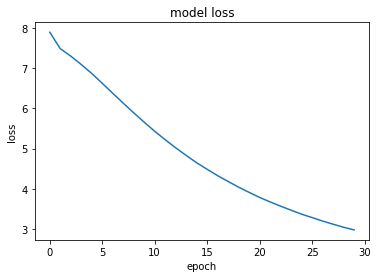

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 6. Make predictions

In [18]:
def predict_next_token(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    prediction = model.predict_classes(token_list, verbose=0)
    return prediction

In [19]:
prediction = predict_next_token("today in new york")
prediction

AttributeError: 'Sequential' object has no attribute 'predict_classes'

WARNING:tensorflow:From <ipython-input-16-bd91571ab9e2>:4: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).

In [20]:
def predict_next_token(seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    prediction = np.argmax(model.predict(token_list), axis=-1)
    return prediction

In [21]:
prediction = predict_next_token("today in new york")
prediction

1/1 [==============================] - 1s 508ms/step


array([9])

In [22]:
tokenizer.sequences_to_texts([prediction])

['is']

In [23]:
# generate new headlines

def generate_headline(seed_text, next_words=1):
    for _ in range(next_words):
        # Predict next token
        prediction = predict_next_token(seed_text)
        # Convert token to word
        next_word = tokenizer.sequences_to_texts([prediction])[0]
        # Add next word to the headline. This headline will be used in the next pass of the loop.
        seed_text += " " + next_word
    # Return headline as title-case
    return seed_text.title()

In [24]:
seed_texts = [
    'washington dc is',
    'today in new york',
    'the school district has',
    'crime has become']
for seed in seed_texts:
    print(generate_headline(seed, next_words=5))

1/1 [==============================] - 0s 18ms/step
Washington Dc Is This Plan To Curb Policies
1/1 [==============================] - 0s 17ms/step
Today In New York Is High Critics Are Not
1/1 [==============================] - 0s 16ms/step
The School District Has The Grid And Luxurious Women
1/1 [==============================] - 0s 16ms/step
Crime Has Become An Idiot Key Police In
